# Example application: computing the tree canopy for the Aussersihl district in Zurich

In this example, we will compute a binary tree canopy map for the [Aussersihl district](https://en.wikipedia.org/wiki/Aussersihl) in Zurich.

In [ ]:
import os
from os import path

import detectree as dtr
import geopandas as gpd
import rasterio as rio
from rasterio import merge

from detectree_examples import (
    make_confusion_df,
    make_response_tiles,
    plot_utils,
    settings,
)

random_state = 10

In [ ]:
img_dir = "../data/interim/aussersihl-tiles"
lidar_tiles_filepath = "../data/raw/lidar/lidar2014.shp"
raw_lidar_dir = "../data/raw/lidar"
response_dir = "../data/interim/response-tiles"
pred_tiles_dir = "../data/interim/aussersihl-pred-tiles"
output_dir = "../data/processed"

Let us now use the Makefile at the root of this repository ensure that we have the required data inputs - i.e., the required tiles from Zurich's RGB orthophoto of summer 2014/15 that lie within Zurich's municipal boundaries - have been downloaded (see the background notebook for more details).

In [ ]:
!make -C .. aussersihl_tiles

make: Entering directory '/home/martibosch/data-science/detectree-examples'
make: Nothing to be done for 'aussersihl_tiles'.
make: Leaving directory '/home/martibosch/data-science/detectree-examples'


## Train/test split

The `make` target above will store the required tiles in the 'data/interim/aussersihl_tiles' directory, which we will pass to the [`TrainingSelector`](https://detectree.readthedocs.io/en/latest/train_test_split.html#detectree.TrainingSelector.__init__) initialization method. For this example, we will use the ['cluster-I'](https://github.com/martibosch/detectree-example/blob/main/notebooks/cluster-I.ipynb) method (see Yang et al. [1]) to select the tiles that will be used to train the tree pixel classifier.

In [ ]:
ts = dtr.TrainingSelector(img_dir=img_dir)
split_df, evr = ts.train_test_split(
    method="cluster-I",
    return_evr=True,
    pca_kwargs={"random_state": random_state},
    kmeans_kwargs={"random_state": random_state},
)

[########################################] | 100% Completed | 6.99 ss


/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/detectree/pixel_features.py:121: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  neighborhood = morphology.square(2 * min_neighborhood_range + 1)
/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

## Interlude: computing the responses from LIDAR data

Since detectree uses a supervised learning approach, we need to manually provide the responses (i.e., binary images representing the ground-truth tree/non-tree masks) for the training tiles so that the tree/non-tree pixel classifier can be trained.

There are many ways to obtain such masks, the most straight-forward being manual edition in a raster graphics editor software such as [GIMP](https://www.gimp.org/). In the case of this example dataset, the ground-truth masks can be extracted from [Zurich's 2014 LIDAR dataset](https://www.geolion.zh.ch/geodatensatz/show?gdsid=343). Such task is accomplished in the two cells below, whose content is out of the scope of detectree.

In [ ]:
!make -C .. download_lidar_shp

make: Entering directory '/home/martibosch/data-science/detectree-examples'
make: Nothing to be done for 'download_lidar_shp'.
make: Leaving directory '/home/martibosch/data-science/detectree-examples'


In [ ]:
lidar_gdf = gpd.read_file(lidar_tiles_filepath)

if not path.exists(response_dir):
    os.mkdir(response_dir)

response_tiles = make_response_tiles.make_response_tiles(
    split_df, lidar_gdf, img_dir, raw_lidar_dir, response_dir
)

## Training the classifier

We can now proceed to the training of the classifier. In detectree, this can be done with the `train_classifier` method of the `ClassifierTrainer` class, which accepts the train/test split data frame as the `split_df` keyword argument (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.train_classifier) for more details). Note that the training of the classifier can take some time.

In [ ]:
clf = dtr.ClassifierTrainer(random_state=random_state).train_classifier(
    split_df=split_df, img_dir=img_dir, response_img_dir=response_dir
)

[                                        ] | 0% Completed | 102.03 ms

/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/detectree/pixel_features.py:121: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  neighborhood = morphology.square(2 * min_neighborhood_range + 1)


[########################################] | 100% Completed | 1.63 ss


/home/martibosch/miniforge3/envs/detectree/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 58302, number of negative: 466698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6871
[LightGBM] [Info] Number of data points in the train set: 525000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111051 -> initscore=-2.080046
[LightGBM] [Info] Start training from score -2.080046


## Predicting tree/non-tree labels

Once the classifier has been trained, it can be used to predict the tree/non-tree labels from any given tile. We will first create a directory where the predicted tiles will be dumped:

In [ ]:
if not path.exists(pred_tiles_dir):
    os.mkdir(pred_tiles_dir)

We can use the `predict_imgs` method of the `Classifier` class, which will predict the tree/non-tree labels for all the testing tiles of `split_df` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.predict_imgs) for more details).

In [ ]:
c = dtr.Classifier(clf=clf)

pred_tiles = c.predict_imgs(split_df, img_dir, output_dir=pred_tiles_dir)

[########################################] | 100% Completed | 84.50 s


## Validation

In order to evaluate the accuracy of the classifier, we can use the code below to build a confusion matrix, which uses the LIDAR dataset to compute the ground-truth masks and then compute the accuracy, precision, recall and F1-score:

In [ ]:
confusion_df = make_confusion_df.make_confusion_df(
    lidar_gdf,
    raw_lidar_dir,
    response_dir,
    split_df=split_df,
    img_dir=img_dir,
    frac=0.02,
    clf=clf,
)
accuracy, precision, recall, f1 = make_confusion_df.compute_metrics(confusion_df)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

[########################################] | 100% Completed | 4.01 ss
Accuracy: 0.9106342857142857
Precision: 0.5880064778356409
Recall: 0.638501456821199
F1: 0.6122145354459572


## Saving the tree canopy map as a single GeoTIFF file

Once we have tree pixels of all tiles, we can use the [`merge` function](https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html?highlight=merge#rasterio.merge.merge) of rasterio to assemble all the tiles into a single file, i.e., the binary tree canopy map.

We will first get a list of all the tree/non-tree tiles, i.e., the ones used for training (`response_tiles`) and the ones used for testing (`pred_tiles`), then read them with rasterio and pass them to the `merge` function:

In [ ]:
canopy_tiles = pred_tiles + response_tiles

canopy_arr, canopy_transform = merge.merge(
    [rio.open(canopy_tile) for canopy_tile in canopy_tiles]
)

We can now plot the result over a basemap (provided by means of the [contextily](https://github.com/geopandas/contextily) library):

<Axes: >

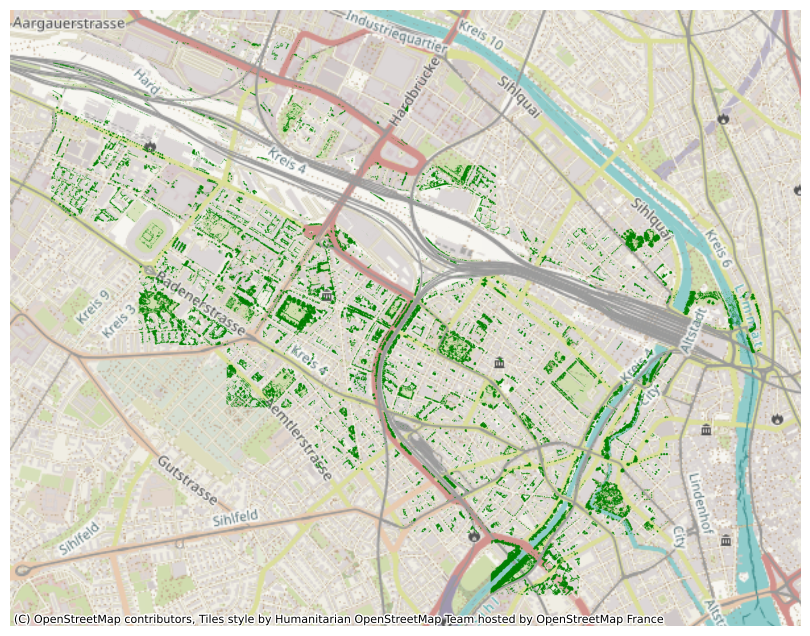

In [ ]:
plot_utils.plot_canopy(canopy_arr, canopy_transform, figsize=(12, 8))

Finally, we can use rasterio to dump the tree canopy array to a GeoTIFF file:

In [ ]:
if not path.exists(output_dir):
    os.mkdir(output_dir)

output_canopy_filepath = path.join(output_dir, "aussersihl-canopy.tif")
output_dtype = rio.uint8

with rio.open(
    output_canopy_filepath,
    "w",
    driver="GTiff",
    width=canopy_arr.shape[2],
    height=canopy_arr.shape[1],
    count=1,
    crs=settings.CRS,
    transform=canopy_transform,
    dtype=output_dtype,
) as dst:
    dst.write(canopy_arr.astype(output_dtype))

## References

1. Yang, L., Wu, X., Praun, E., & Ma, X. (2009). Tree detection from aerial imagery. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (pp. 131-137). ACM.